In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt
%matplotlib inline 
import matplotlib.image as mpimg
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)

def camera_calibration(images):
    #print "camera_calibration"
    global mtx,dist
    objp = np.zeros((6*9,3), np.float32)

    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    # Step through the list and search for chessboard corners
    for fname in images:
     
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)#cv2.imread is BGR, mpimg.imread is RGB

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None) # 9x6: Number of inner corners per a chessboard row and column
      
        #If found, add object points, image points
        if ret == True: ##calibration1.img, calibarion14.img and calibration15.img are not compatiable with (9,6), this fine.
            objpoints.append(objp)
            imgpoints.append(corners)
            ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return (mtx,dist)

In [2]:

def color_gradient_threshold(img, s_thresh=(170, 255),  v_thresh=(180, 255),l_thresh=(170, 255),rg_thresh=(200, 255),sx_thresh=(40, 255)):

    img = np.copy(img)
    r_channel = img[:,:,0]
    g_channel = img[:,:,1]
    b_channel = img[:,:,2]
    
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float)
    v_channel = hsv[:,:,2]
    
    # Convert to HSV color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=3) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient    
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    # Threshold color channel
    s_binary = np.zeros_like(s_channel) # bright yellow&white
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    l_binary = np.zeros_like(l_channel) # avoid shadow
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    
    r_binary = np.zeros_like(s_channel) # RG for yellow lane
    r_binary[(r_channel >= rg_thresh[0]) & (r_channel <= rg_thresh[1])] = 1
    
    g_binary = np.zeros_like(l_channel) # RG for yellow lane
    g_binary[(g_channel >= rg_thresh[0]) & (g_channel <= rg_thresh[1])] = 1
    
    v_binary = np.zeros_like(v_channel) # RG for yellow lane
    v_binary[(v_channel >= v_thresh[0]) & (v_channel <= v_thresh[1])] = 1
    
    #print (s_binary)
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    #combined_binary[(s_binary == 1) | (sxbinary == 1) | (l_binary == 1)| (r_binary == 1)| (g_binary == 1)] = 1
    #combined_binary[(sxbinary == 1) | (s_binary == 1) | (l_binary == 1)| (r_binary == 1)&(g_binary == 1)|(v_binary==1)] = 1
    combined_binary[(sxbinary == 1) |(r_binary == 1)|(v_binary==1)] = 1
    return combined_binary


In [3]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


In [4]:
def image_warpper(image,src,dst):
    global Minv
    global M
    
    imshape=image.shape
    img_size = (imshape[1], imshape[0])
    global vertices_y_top 
    vertices_y_top =390
    vertices = np.array([[(0,imshape[0]),(670, vertices_y_top), (690, vertices_y_top), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_image=region_of_interest(image,vertices)
    plt.imshow(masked_image)
    plt.show()
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(masked_image, M, img_size)
    plt.imshow(warped)
    plt.show()
    Minv = cv2.getPerspectiveTransform(dst, src)
    return (warped,Minv)

In [5]:
import numpy as np

def cal_histogram(warped):
    #print "cal_histogram"
    histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
    plt.plot(histogram)
    plt.show()
    return histogram
    

scan through the image from bottom to top

In [6]:

def sliding_window(warped, histogram):
    global left_fit
    global right_fit
    global leftx_base
    global rightx_base
    #print "sliding_window"
    out_img = np.dstack((warped, warped, warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped.shape[0] - (window+1)*window_height
        win_y_high = warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    #visulize_curvewindow
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] ) #Return evenly spaced numbers over a specified interval.
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    #print len(left_fitx)
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.show()
    
    #Visulize the found lanes

    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((warped, warped, warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    #plt.imshow(result)
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    #plt.xlim(0, 1280)
    #plt.ylim(720, 0)
    #plt.show() 
    return (ploty,left_fit,right_fit,left_fitx,right_fitx,leftx_base,rightx_base)
    
    




In [7]:
# calculate the radius of curvature as follows
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
def cal_radius(ploty):
    
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    #print (left_curverad,right_curverad)
    return (left_curverad,right_curverad)
    #print(left_curverad, right_curverad)



In [8]:
def cal_radius_inspace(ploty,left_fitx,right_fitx,distance):
    
    y_eval = np.max(ploty)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30.0/720 # meters per pixel in y dimension
    #xm_per_pix = 3.7/700 # meters per pixel in x dimension
    xm_per_pix = 3.7/distance # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    curverad = (left_curverad + right_curverad)/2
    #print curverad
    return (curverad)
    

In [9]:
def draw_lanes_area(image,warped,ploty,left_fitx,right_fitx,Minv):
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    return result



In [10]:
def find_lanes_skipsliding(warped):
    global left_fit
    global right_fit
    #print "skip sliding"
    # Assume now we have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    leftx_base=left_fit[0]*warped.shape[0]**2 + left_fit[1]*warped.shape[0] + left_fit[2]
    rightx_base=right_fit[0]*warped.shape[0]**2 + right_fit[1]*warped.shape[0] + right_fit[2]
    return (ploty,left_fitx,right_fitx,leftx_base,rightx_base)

In [11]:
def pipeline(image,mtx,dist):
    global left_fit
    global right_fit
    global leftx_base
    global rightx_base
    global left_fitx_sum
    global right_fitx_sum
    global left_fitx_array
    global right_fitx_array
    global Minv

    
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    plt.imshow(undist)
    plt.show()
    result = color_gradient_threshold(undist)
    plt.imshow(result)
    plt.show()
    
    src = np.float32([[833,544],[939,611],[360,611],[463,544]])
    dst = np.float32([[939,544],[939,611],[360,611],[360,544]])
    (warped,Minv)=image_warpper(result,src,dst)
 
    histogram=cal_histogram(warped)
 
    if counter>2:
         (ploty,left_fitx,right_fitx,leftx_base,rightx_base)=find_lanes_skipsliding(warped)
    else:
        (ploty,left_fit,right_fit,left_fitx,right_fitx,leftx_base,rightx_base)=sliding_window(warped,histogram)

   
    left_fitx_array.append(left_fitx.tolist())
    right_fitx_array.append(right_fitx.tolist())    

    left_fitx_array_np=np.array(left_fitx_array)
    right_fitx_array_np=np.array(right_fitx_array)
    if counter>10:
        left_fitx_sum=sum(left_fitx_array_np[-10:])
        right_fitx_sum=sum(right_fitx_array_np[-10:])
        left_fitx=left_fitx_sum / 10
        right_fitx=right_fitx_sum /10
    distance=rightx_base-leftx_base
    curverad=cal_radius_inspace(ploty,left_fitx,right_fitx,distance)                      
    found_lines=draw_lanes_area(image,warped,ploty,left_fitx,right_fitx,Minv)

    xm_per_pix = 3.7/distance # meters per pixel in x dimension
    offset = (image.shape[1]*0.5-((distance)*0.5+leftx_base))*xm_per_pix

    if offset>0:
        direction="right"
    else:
        direction="left"
        offset = -offset
    cv2.putText(found_lines,"Radius of the Curvature is "+str(int(curverad))+'(m)', (80,120), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255),2,cv2.LINE_AA)
    cv2.putText(found_lines,"vehicle is "+ str(round(offset,3))+ "(m) "+ direction + " of center", (80,220), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255),2,cv2.LINE_AA)

    return found_lines




In [12]:
left_fitx_sum=0
right_fitx_sum=0
left_fitx_array=[]
right_fitx_array=[]
def main():
    global counter
    
    counter=0
    images = glob.glob('./camera_cal/calibration*.jpg')
    camera_calibration(images)
    image = mpimg.imread('./test_images/test3.jpg')
    plt.imshow(image)
    plt.show()
    counter=1
    print "Start Executing the Pipeline"
    returned=pipeline(image,mtx,dist)
    plt.imshow(returned)
    plt.show()
    #counter=13
    #image = mpimg.imread('../test_images/test4.jpg')
    #plt.imshow(image)
    #plt.show()
    #counter=1
    #print "Start Executing the Pipeline"
    #returned=pipeline(image,mtx,dist)
    #counter=counter+1
    #plt.imshow(returned)
    #plt.imshow(found_lines)
    #plt.show()
    

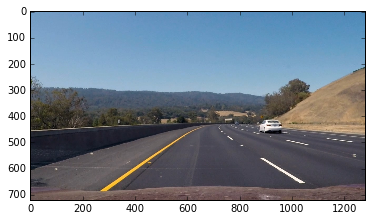

Start Executing the Pipeline


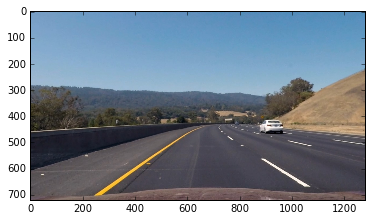

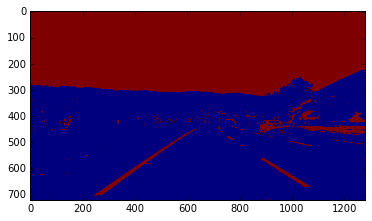

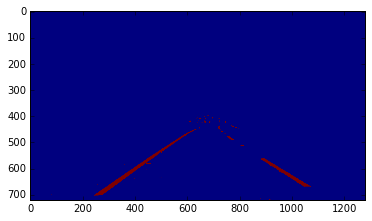

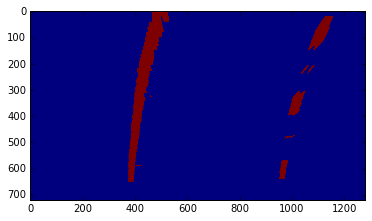

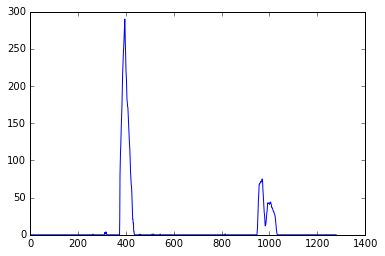

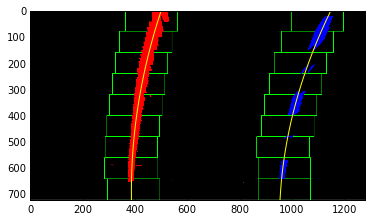

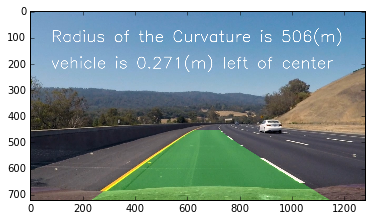

In [13]:

if __name__ == "__main__":main() ## with if

In [ ]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import imageio
imageio.plugins.ffmpeg.download()

In [ ]:
def process_image(image):
    global counter
    image_returned=pipeline(image,mtx,dist)
    counter=counter+1
    
    return image_returned

In [ ]:
#global counter
counter=0
left_fitx_sum=0
right_fitx_sum=0
left_fitx_array=[]
right_fitx_array=[]
images = glob.glob('./camera_cal/calibration*.jpg')
camera_calibration(images)
white_output = './project_video_output.mp4'
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)